# Fitting a Model on PAD-UFES data

To change to ISIC, you should be able to simply change the string in the load_dataset area.

In [40]:
#!/usr/bin/env python3
from typing import Callable, Tuple
from collections import Counter
from pathlib import Path
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from tensorflow import config, keras
# Limit GPU Memory space. By default, Tensorflow eats up 100% of available GPU memory, which can be annoying.
gpus = config.experimental.list_physical_devices('GPU')
if len(gpus) > 0: # If there is any GPU available
    config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 16 = 16GB

from cascid.datasets.pipeline import load_dataset
from cascid.models.ResNet import ResNet

EPOCHS = 2
BATCH_SIZE = 128
ES_PATIENCE = 5
IMAGE_SHAPE = (256,256,3)
LEARNING_RATE = 0.0001

## Loading and Encoding data

The first step is to load and prepare the data. Cascid makes this very easy, through use of the 'train_test_split' function inside the 'pipeline.load_dataset' module.

In [45]:
x_train, x_test, y_train, y_test = load_dataset.train_test_split('pad', 'hairless', image_shape=IMAGE_SHAPE[:2])

print("x_train shape: {0}".format(x_train.shape))
print("x_test shape: {0}".format(x_test.shape))
print("y_train shape: {0}".format(y_train.shape))
print("y_test shape: {0}".format(y_test.shape))

# In this example, we are using binary classification, so we compress the 6 diagnosis into 2 categories and One Hot Encode them (for compatibility with use cases with more than two classes).
y_train=np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_train))).reshape(-1,1)
y_test=np.array(list(map(lambda x: "Cancer" if x in ['BCC', 'MEL', 'SCC'] else "Not", y_test))).reshape(-1,1)

# Before One-Hot encoding, it's interesting to analyse the frequency of each class 
cnt = Counter(y_train.flatten().tolist() + y_test.flatten().tolist())
total = cnt["Cancer"] + cnt["Not"]
cnt["Cancer"] /= total
cnt["Not"] /= total
ratio = max(cnt["Cancer"], cnt["Not"])

# One Hot Encode
OHE = OneHotEncoder(sparse=False)
y_train = OHE.fit_transform(y_train)

Loading hairless pad dataset, this may take a minute, but caching is done automatically, so the next time it should be much faster.
x_train shape: (1838, 256, 256, 3)
x_test shape: (460, 256, 256, 3)
y_train shape: (1838, 1)
y_test shape: (460, 1)


It's good to visualize the data, to make sure that everything is in order.

Diagnosis:  Not


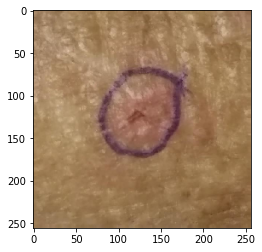

In [39]:
# Show image
plt.imshow(x_train[0][:,:,::-1])
# Print class label for this image
print("Diagnosis: ", OHE.inverse_transform([y_train[0]])[0][0]) 

## Creating the Model

Cascid's models module has a ResNet implementation available for importing. After that, everything is pretty standard keras and sklearn.

In [5]:
resnet_size = (2,2,2,2) # Standard ResNet18 sizes
model = ResNet(IMAGE_SHAPE ,*resnet_size, quantized=False, augmentation=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(), # Binary classification loss
    metrics=['acc', keras.metrics.AUC()] # loss is implied
)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 256, 256, 3)      0         
 se)                                                             
                                                                 
 random_brightness (RandomBr  (None, 256, 256, 3)      0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                        

In [7]:
ES = keras.callbacks.EarlyStopping( # Optional early stopping
    monitor='val_loss',
    patience=ES_PATIENCE,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [8]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Validation split for val_acc
    verbose=1,
    callbacks=[ES],
)

Epoch 1/2
12/12 [==============================] - 185s 15s/step - loss: 0.6947 - acc: 0.4646 - auc: 0.4672 - val_loss: 0.6945 - val_acc: 0.4701 - val_auc: 0.4701
Epoch 2/2
12/12 [==============================] - 180s 15s/step - loss: 0.6932 - acc: 0.4687 - auc: 0.5254 - val_loss: 0.6944 - val_acc: 0.4701 - val_auc: 0.4701


## Performance

In this example, the model is only trained for 2 Epochs, as stated by the global variable in the first cell. As such, performance will obviously be terrible, but it's enough to visualize how it would work.

In [31]:
y_pred_test = model.predict(x_test)
y_pred_test = OHE.inverse_transform(y_pred_test)

y_pred_train = model.predict(x_train)
y_pred_train = OHE.inverse_transform(y_pred_train)

58/58 [==============================] - 38s 663ms/step


It's important to analyze performance both on train and test data, to identify overfitting.

In [46]:
print("Baseline accuracy must be {} (class ratio)".format(ratio))
print("Model score on train is: {}".format(accuracy_score(OHE.inverse_transform(y_train), y_pred_train)))
print("Model score on test is: {}".format(accuracy_score(y_test, y_pred_test)))

Baseline accuracy must be 0.5261096605744126 (class ratio)
Model score on train is: 0.46517954298150166
Model score on test is: 0.508695652173913


In [48]:
print("Model score on train is:\n{}".format(confusion_matrix(OHE.inverse_transform(y_train), y_pred_train)))
print("Model score on test is:\n{}".format(confusion_matrix(y_test, y_pred_test)))

Model score on train is:
[[855   0]
 [983   0]]
Model score on test is:
[[234   0]
 [226   0]]


And as can be seen by the confusion matrixes above, the model is completely underfitting after 2 epochs. It hasn't had time to learn anything, and is just barely guessing one class every time.